--- Analyzing Distribution of Pair-Eligible 'Used' Papers ---

--- Summary Statistics ---
ペア作成が可能なデータ論文の総数 ('Used'論文が2件以上): 721

[Distribution of 'Used' Paper Counts (for this eligible group)]


count    721.000000
mean       4.468793
std        9.089184
min        2.000000
25%        2.000000
50%        2.000000
75%        4.000000
max      179.000000
Name: used_paper_count, dtype: float64


[Histogram of the Distribution]


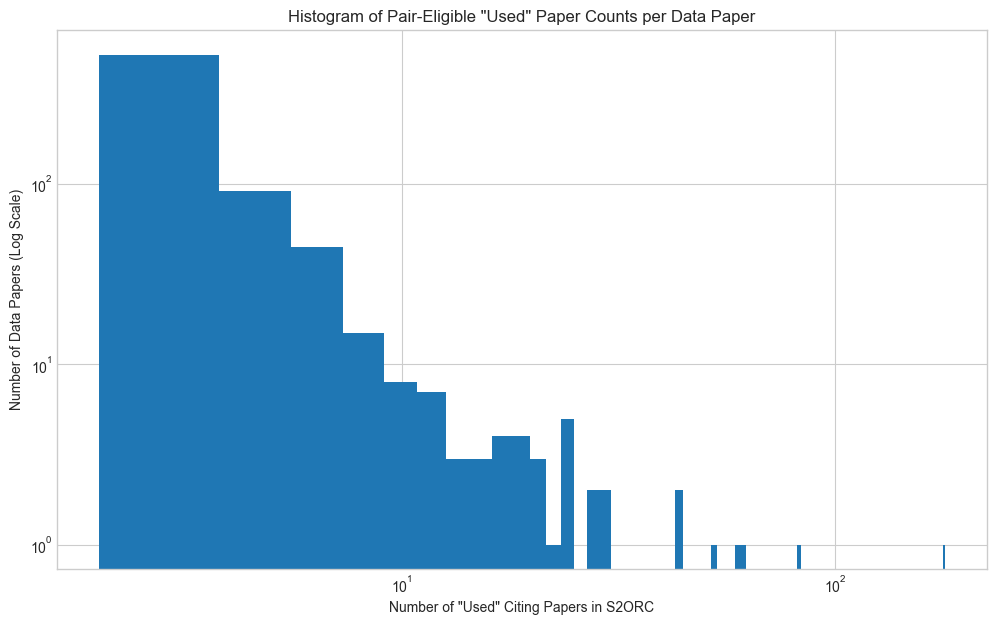

In [14]:
import pandas as pd
import sqlite3
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# --- Step 1: 設定 ---
DB_PATH = "../data/processed/s2orc_filtered.db"

# --- Step 2: データベースの分析 ---

def analyze_pair_eligible_used_distribution():
    """
    'Used'と判定された論文が2件以上あるデータ論文のみを対象に、
    その分布を調査・可視化する。
    """
    print("--- Analyzing Distribution of Pair-Eligible 'Used' Papers ---")

    if not os.path.exists(DB_PATH):
        print(f"❌ Error: Database file not found at {DB_PATH}")
        return

    try:
        with sqlite3.connect(DB_PATH) as conn:
            # テーブルの存在を確認
            cursor = conn.cursor()
            cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name='positive_candidates'")
            if cursor.fetchone() is None:
                print("⚠️ `positive_candidates` table not found.")
                return

            # --- 2.1: 'Used'と判定された論文をデータ論文ごとに集計 ---
            query = """
                SELECT
                    cited_datapaper_doi,
                    COUNT(citing_doi) AS used_paper_count
                FROM
                    positive_candidates
                WHERE
                    annotation_status = 1
                GROUP BY
                    cited_datapaper_doi
                HAVING
                    COUNT(citing_doi) >= 2;
            """
            df_counts = pd.read_sql_query(query, conn)
            
            if df_counts.empty:
                print("\nNo data papers found with 2 or more 'Used' citing papers.")
                return

            # --- 2.2: 主要な統計情報を表示 ---
            total_data_papers_eligible = len(df_counts)
            
            print("\n--- Summary Statistics ---")
            print(f"ペア作成が可能なデータ論文の総数 ('Used'論文が2件以上): {total_data_papers_eligible:,}")
            
            print("\n[Distribution of 'Used' Paper Counts (for this eligible group)]")
            display(df_counts['used_paper_count'].describe())

            # --- 2.3: 分布をヒストグラムで可視化 ---
            plt.style.use('seaborn-v0_8-whitegrid')
            plt.figure(figsize=(12, 7))
            
            # 対数スケールで表示
            # ビンの数を調整して、より詳細な分布が見えるようにする
            max_count = df_counts['used_paper_count'].max()
            bins = int(max_count) if max_count < 100 else 100
            plt.hist(df_counts['used_paper_count'], bins=bins, log=True)
            
            plt.title('Histogram of Pair-Eligible "Used" Paper Counts per Data Paper')
            plt.xlabel('Number of "Used" Citing Papers in S2ORC')
            plt.ylabel('Number of Data Papers (Log Scale)')
            # x軸も対数スケールにすると、高引用数の分布がより分かりやすくなる
            plt.xscale('log')
            
            print("\n[Histogram of the Distribution]")
            plt.show()

    except Exception as e:
        print(f"💥 An error occurred: {e}")

# --- 実行 ---
analyze_pair_eligible_used_distribution()

In [15]:
import pandas as pd
import sqlite3
import os
from IPython.display import display

# --- Step 1: 設定 ---
DB_PATH = "../data/processed/s2orc_filtered.db"
OUTPUT_DIR = "../data/datapapers/sampled/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

EVAL_SET_TARGET_SIZE = 100 # 評価用データ論文の目標件数

def final_split_datapapers():
    """
    'Used'論文数に基づき、系統抽出法でデータ論文を訓練用と評価用に分割する。
    """
    print("--- Final Split of Data Papers based on 'Used' Counts ---")

    with sqlite3.connect(DB_PATH) as conn:
        # 1. 'Used'と判定された論文が2件以上あるデータ論文を、Used論文数が多い順に取得
        query = """
            SELECT
                cited_datapaper_doi,
                COUNT(citing_doi) AS used_paper_count
            FROM
                positive_candidates
            WHERE
                annotation_status = 1
            GROUP BY
                cited_datapaper_doi
            HAVING
                COUNT(citing_doi) >= 2
            ORDER BY
                used_paper_count DESC;
        """
        df_eligible = pd.read_sql_query(query, conn)
        
        if len(df_eligible) < (EVAL_SET_TARGET_SIZE * 4):
            print(f"⚠️ Warning: Not enough eligible papers ({len(df_eligible)}) to create the desired sample size.")
        else:
            print(f"Found {len(df_eligible):,} eligible data papers to sample from.")

    # 2. 「訓練3件、評価1件」のルールでサンプリング
    training_dois = []
    evaluation_dois = []
    
    for index, row in df_eligible.iterrows():
        if len(evaluation_dois) >= EVAL_SET_TARGET_SIZE:
            break
        
        # 4番目, 8番目, 12番目...を評価用とする
        if (index + 1) % 4 == 0:
            evaluation_dois.append(row['cited_datapaper_doi'])
        else:
            training_dois.append(row['cited_datapaper_doi'])

    # 3. 最終的なDataFrameを作成
    df_train = df_eligible[df_eligible['cited_datapaper_doi'].isin(training_dois)]
    df_eval = df_eligible[df_eligible['cited_datapaper_doi'].isin(evaluation_dois)]
    
    # 4. CSVとして保存
    df_train.to_csv(os.path.join(OUTPUT_DIR, "training_data_papers.csv"), index=False)
    df_eval.to_csv(os.path.join(OUTPUT_DIR, "evaluation_data_papers.csv"), index=False)

    print("\n--- Split Results ---")
    print(f"Total papers sampled: {len(df_train) + len(df_eval)}")
    print(f"Final training set size: {len(df_train):,} data papers")
    print(f"Final evaluation set size: {len(df_eval):,} data papers")

    print("\n--- Sample of Evaluation Set (Top 5 by 'Used' count) ---")
    display(df_eval.head(5))

# --- 実行 ---
final_split_datapapers()

--- Final Split of Data Papers based on 'Used' Counts ---
Found 721 eligible data papers to sample from.

--- Split Results ---
Total papers sampled: 400
Final training set size: 300 data papers
Final evaluation set size: 100 data papers

--- Sample of Evaluation Set (Top 5 by 'Used' count) ---


,cited_datapaper_doi,used_paper_count
3,10.1007/S11558-019-09344-2,60
7,10.5194/ESSD-13-3907-2021,30
11,10.5194/ESSD-14-1917-2022,25
15,10.1002/GDJ3.44,24
19,10.1016/J.DIB.2017.10.024,20


--- Analyzing Training Set Distribution ---
Total data papers: 300


count    300.000000
mean       6.643333
std       12.994060
min        2.000000
25%        3.000000
50%        3.500000
75%        6.000000
max      179.000000
Name: used_paper_count, dtype: float64


--- Analyzing Evaluation Set Distribution ---
Total data papers: 100


count    100.000000
mean       5.870000
std        7.402777
min        2.000000
25%        3.000000
50%        3.500000
75%        6.000000
max       60.000000
Name: used_paper_count, dtype: float64

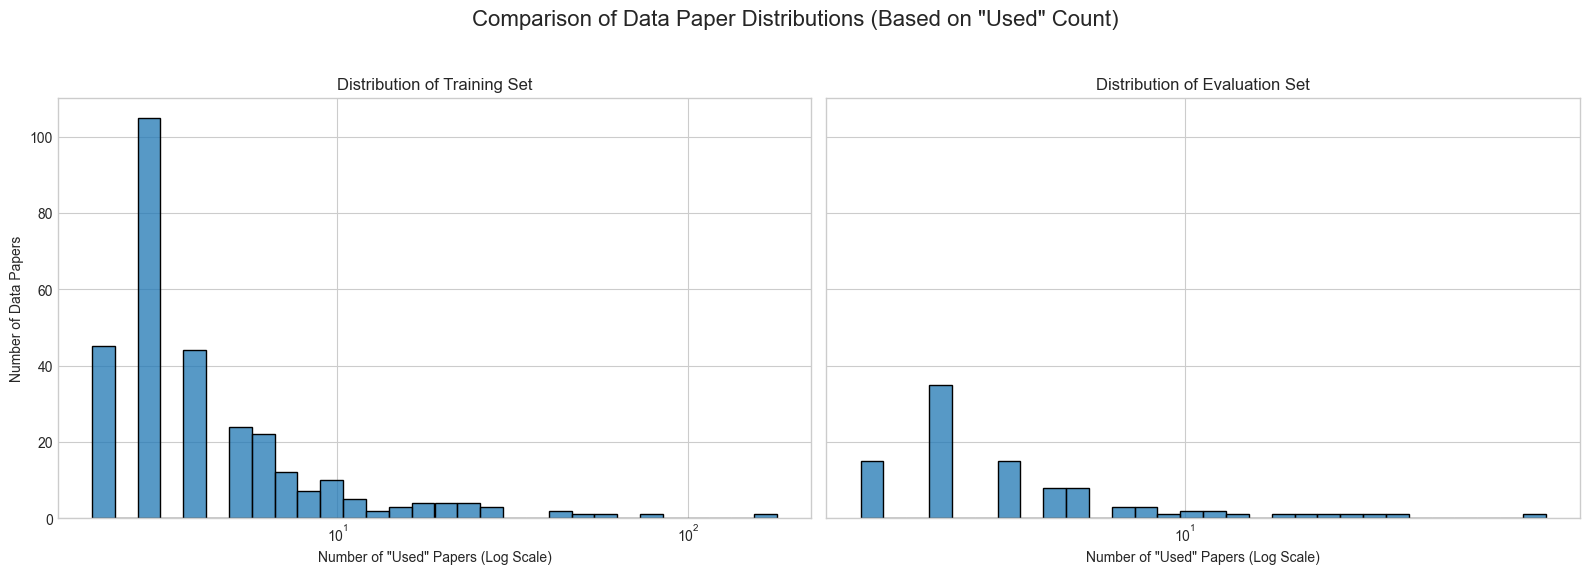

In [19]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# --- Step 1: 設定 ---
SAMPLED_DIR = "../data/datapapers/sampled/"
TRAINING_FILE = os.path.join(SAMPLED_DIR, "training_data_papers.csv")
EVALUATION_FILE = os.path.join(SAMPLED_DIR, "evaluation_data_papers.csv")

# --- Step 2: 分布の分析と可視化 ---

def analyze_split_distributions():
    """
    訓練用・評価用データセットの'used_paper_count'分布を分析・可視化する
    """
    if not (os.path.exists(TRAINING_FILE) and os.path.exists(EVALUATION_FILE)):
        print("❌ Error: Training or evaluation file not found. Please run the split script first.")
        return

    # --- 2.1: データの読み込み ---
    df_train = pd.read_csv(TRAINING_FILE)
    df_eval = pd.read_csv(EVALUATION_FILE)

    # カラム名をユーザーの指定に合わせて変更（もし異なっている場合）
    if 'used_paper_count' not in df_train.columns and 's2orc_citing_count' in df_train.columns:
        df_train.rename(columns={'s2orc_citing_count': 'used_paper_count'}, inplace=True)
    if 'used_paper_count' not in df_eval.columns and 's2orc_citing_count' in df_eval.columns:
        df_eval.rename(columns={'s2orc_citing_count': 'used_paper_count'}, inplace=True)

    print("--- Analyzing Training Set Distribution ---")
    print(f"Total data papers: {len(df_train):,}")
    display(df_train['used_paper_count'].describe())

    print("\n" + "="*50)
    print("--- Analyzing Evaluation Set Distribution ---")
    print(f"Total data papers: {len(df_eval):,}")
    display(df_eval['used_paper_count'].describe())

    # --- 2.2: ヒストグラムで可視化 ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    
    # 訓練用データセットのグラフ
    sns.histplot(data=df_train, x='used_paper_count', ax=axes[0], bins=30, log_scale=True)
    axes[0].set_title('Distribution of Training Set')
    axes[0].set_xlabel('Number of "Used" Papers (Log Scale)')
    axes[0].set_ylabel('Number of Data Papers')
    
    # 評価用データセットのグラフ
    sns.histplot(data=df_eval, x='used_paper_count', ax=axes[1], bins=30, log_scale=True)
    axes[1].set_title('Distribution of Evaluation Set')
    axes[1].set_xlabel('Number of "Used" Papers (Log Scale)')
    
    plt.suptitle('Comparison of Data Paper Distributions (Based on "Used" Count)', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- 実行 ---
analyze_split_distributions()

In [20]:
import pandas as pd
import os

# --- Step 1: 設定 ---
TRAINING_DATAPAPERS_FILE = "../data/datapapers/sampled/training_data_papers.csv"
NEGATIVE_SAMPLE_RATIO = 4 # 正例1に対する負例の数

# --- Step 2: 訓練データセット規模の見積もり ---

def estimate_final_training_size():
    """
    目視確認を1件行うという前提で、構築可能な訓練データセットの規模を見積もる。
    """
    print("--- Estimating Final Training Set Size based on Manual Verification ---")

    if not os.path.exists(TRAINING_DATAPAPERS_FILE):
        print(f"❌ Error: Training data paper file not found at {TRAINING_DATAPAPERS_FILE}")
        return

    try:
        # 1. 訓練用のデータ論文リストを読み込む
        df_train = pd.read_csv(TRAINING_DATAPAPERS_FILE)

        # カラム名が 's2orc_citing_count' または 'used_paper_count' のいずれかであることを確認
        if 'used_paper_count' in df_train.columns:
            count_col = 'used_paper_count'
        elif 's2orc_citing_count' in df_train.columns:
            count_col = 's2orc_citing_count'
        else:
            print("❌ Error: Count column ('used_paper_count' or 's2orc_citing_count') not found.")
            return

        # 2. 作成可能なペア数を計算 (k件からk-1ペア)
        # 'Used'論文が2件以上あることが前提
        df_train['creatable_pairs'] = df_train[count_col] - 1
        
        # 3. 全ての数値を合計
        total_positive_pairs = df_train['creatable_pairs'].sum()
        num_manual_verifications = len(df_train)

        # --- 3. 結果の報告 ---
        print("\n" + "="*50)
        print("--- Estimation Results for Training Dataset ---")
        print(f"訓練データ作成の起点となるデータ論文数: {num_manual_verifications:,}")
        print(f"⇒ 目視確認が必要な論文総数: {num_manual_verifications:,}件")
        print("-" * 50)
        print(f"作成可能な正例ペアの総数: {int(total_positive_pairs):,}")
        print("="*50)
        
        print(f"\n--- Total Dataset Size Estimation (Positive:Negative = 1:{NEGATIVE_SAMPLE_RATIO}) ---")
        total_negative_pairs = total_positive_pairs * NEGATIVE_SAMPLE_RATIO
        total_dataset_size = total_positive_pairs + total_negative_pairs
        print(f"  - Negative Pairs to be sampled: {int(total_negative_pairs):,}")
        print(f"  - Total Estimated Dataset Size: {int(total_dataset_size):,} pairs")


    except Exception as e:
        print(f"💥 An error occurred: {e}")

# --- 実行 ---
estimate_final_training_size()

--- Estimating Final Training Set Size based on Manual Verification ---

--- Estimation Results for Training Dataset ---
訓練データ作成の起点となるデータ論文数: 300
⇒ 目視確認が必要な論文総数: 300件
--------------------------------------------------
作成可能な正例ペアの総数: 1,693

--- Total Dataset Size Estimation (Positive:Negative = 1:4) ---
  - Negative Pairs to be sampled: 6,772
  - Total Estimated Dataset Size: 8,465 pairs


In [22]:
import pandas as pd
import sqlite3
import os
from IPython.display import display

# --- Step 1: 設定 ---
DB_PATH = "../data/processed/s2orc_filtered.db"
EVAL_SET_TARGET_SIZE = 100

# ▼▼▼ 検証したいサンプリング間隔をリストで指定 ▼▼▼
# 例: 3 -> 2件訓練/1件評価, 4 -> 3件訓練/1件評価, 5 -> 4件訓練/1件評価
SAMPLING_INTERVALS = [3, 4, 5, 8, 10]

def evaluate_splitting_strategies_on_used():
    """
    'Used'論文が2件以上あるデータ論文を母集団として、
    複数のサンプリング間隔を試し、それぞれの分割結果の統計情報を比較する。
    """
    print("--- Evaluating Splitting Strategies (Population: 'Used' Count >= 2) ---")

    with sqlite3.connect(DB_PATH) as conn:
        # 1. 'Used'と判定された論文が2件以上あるデータ論文を、Used論文数が多い順に取得
        query = """
            SELECT
                cited_datapaper_doi,
                COUNT(citing_doi) AS used_paper_count
            FROM
                positive_candidates
            WHERE
                annotation_status = 1
            GROUP BY
                cited_datapaper_doi
            HAVING
                COUNT(citing_doi) >= 2
            ORDER BY
                used_paper_count DESC;
        """
        df_eligible = pd.read_sql_query(query, conn)
        
        if df_eligible.empty:
            print("No data papers found with 2 or more 'Used' citing papers.")
            return
            
        print(f"Found {len(df_eligible):,} eligible data papers to sample from.")

    results_summary = {}

    # 2. 各サンプリング間隔でループ処理
    for interval in SAMPLING_INTERVALS:
        training_dois = []
        evaluation_dois = []
        
        for index, row in df_eligible.iterrows():
            if len(evaluation_dois) >= EVAL_SET_TARGET_SIZE:
                break
            
            # interval番目ごとに評価用とする
            if (index + 1) % interval == 0:
                evaluation_dois.append(row['cited_datapaper_doi'])
            else:
                training_dois.append(row['cited_datapaper_doi'])
        
        # 分割されたDataFrameを作成
        df_train = df_eligible[df_eligible['cited_datapaper_doi'].isin(training_dois)]
        df_eval = df_eligible[df_eligible['cited_datapaper_doi'].isin(evaluation_dois)]
        
        # 統計情報を辞書に格納
        strategy_name = f"Train:{interval-1}, Eval:1"
        results_summary[strategy_name] = {
            "Training Set Stats": df_train['used_paper_count'].describe(),
            "Evaluation Set Stats": df_eval['used_paper_count'].describe()
        }

    # --- 3. 結果をまとめて表示 ---
    print("\n" + "="*80)
    print("--- Comparison of Sampling Strategy Results ---")
    
    for strategy, stats in results_summary.items():
        print(f"\n▼▼▼ Strategy: {strategy} ▼▼▼")
        print("\n[Training Set Distribution]")
        display(stats["Training Set Stats"].to_frame())
        print("\n[Evaluation Set Distribution]")
        display(stats["Evaluation Set Stats"].to_frame())
        print("="*80)

# --- 実行 ---
evaluate_splitting_strategies_on_used()

--- Evaluating Splitting Strategies (Population: 'Used' Count >= 2) ---
Found 721 eligible data papers to sample from.

--- Comparison of Sampling Strategy Results ---

▼▼▼ Strategy: Train:2, Eval:1 ▼▼▼

[Training Set Distribution]


,used_paper_count
count,200.000000
mean,8.145000
std,15.311964
min,3.000000
25%,3.000000
50%,4.000000
75%,7.000000
max,179.000000



[Evaluation Set Distribution]


,used_paper_count
count,100.000000
mean,7.110000
std,8.418228
min,3.000000
25%,3.000000
50%,4.000000
75%,7.000000
max,62.000000



▼▼▼ Strategy: Train:3, Eval:1 ▼▼▼

[Training Set Distribution]


,used_paper_count
count,300.000000
mean,6.643333
std,12.994060
min,2.000000
25%,3.000000
50%,3.500000
75%,6.000000
max,179.000000



[Evaluation Set Distribution]


,used_paper_count
count,100.000000
mean,5.870000
std,7.402777
min,2.000000
25%,3.000000
50%,3.500000
75%,6.000000
max,60.000000



▼▼▼ Strategy: Train:4, Eval:1 ▼▼▼

[Training Set Distribution]


,used_paper_count
count,400.000000
mean,5.692500
std,11.562316
min,2.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,179.000000



[Evaluation Set Distribution]


,used_paper_count
count,100.000000
mean,5.030000
std,6.484566
min,2.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,52.000000



▼▼▼ Strategy: Train:7, Eval:1 ▼▼▼

[Training Set Distribution]


,used_paper_count
count,631.000000
mean,4.548336
std,9.573631
min,2.000000
25%,2.000000
50%,2.000000
75%,4.000000
max,179.000000



[Evaluation Set Distribution]


,used_paper_count
count,90.000000
mean,3.911111
std,4.379843
min,2.000000
25%,2.000000
50%,2.000000
75%,4.000000
max,30.000000



▼▼▼ Strategy: Train:9, Eval:1 ▼▼▼

[Training Set Distribution]


,used_paper_count
count,649.000000
mean,4.534669
std,9.476862
min,2.000000
25%,2.000000
50%,2.000000
75%,4.000000
max,179.000000



[Evaluation Set Distribution]


,used_paper_count
count,72.000000
mean,3.875000
std,4.205756
min,2.000000
25%,2.000000
50%,2.000000
75%,4.000000
max,28.000000
